<a href="https://colab.research.google.com/github/gabrieladamasceno/Model_Attacks/blob/main/Autoencoder_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
pip install imbalanced-learn


In [51]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [52]:
!pip install gputil


In [53]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [54]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [55]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Monitor Resource =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Training =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Start of Training]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Start] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        print(f"[Epoch {epoch + 1} - End] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Prediction/Test =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Start of Prediction/Test]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Energy
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Graphs
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memory
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


====== Zero-Day: ICMPFlood ======
Total ICMPFlood in the original dataset: 1155
  Zero-days removed from training: 917
  Zero-day in the original test: 238
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 4486.61 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 3731.03 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 3731.01 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 3748.00 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 3747.97 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 3770.36 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 3770.33 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3772.49 MB

[Epoch 5 - Start] CPU: 1.20%, Memory: 3772.46 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3772.92 MB

[Epoch 6 - Start] CPU: 15.00%, Memory: 3772.89 MB
[Epoch 6 - End] CPU: 1.20%, Memory: 3774.41 MB

[Epoch 7 - Start] CPU: 1.20%, Memory: 3774.38 MB
[Epoch 7 - End] CPU: 0.00%, Memory: 3775.76 MB

[Epoch 8 - Start] CPU: 0.00%, Memory: 3775.73 MB
[Epoch 8 - End] CPU: 2.50%, Memory: 3781.18 MB

[Epoch 9 - Start] 

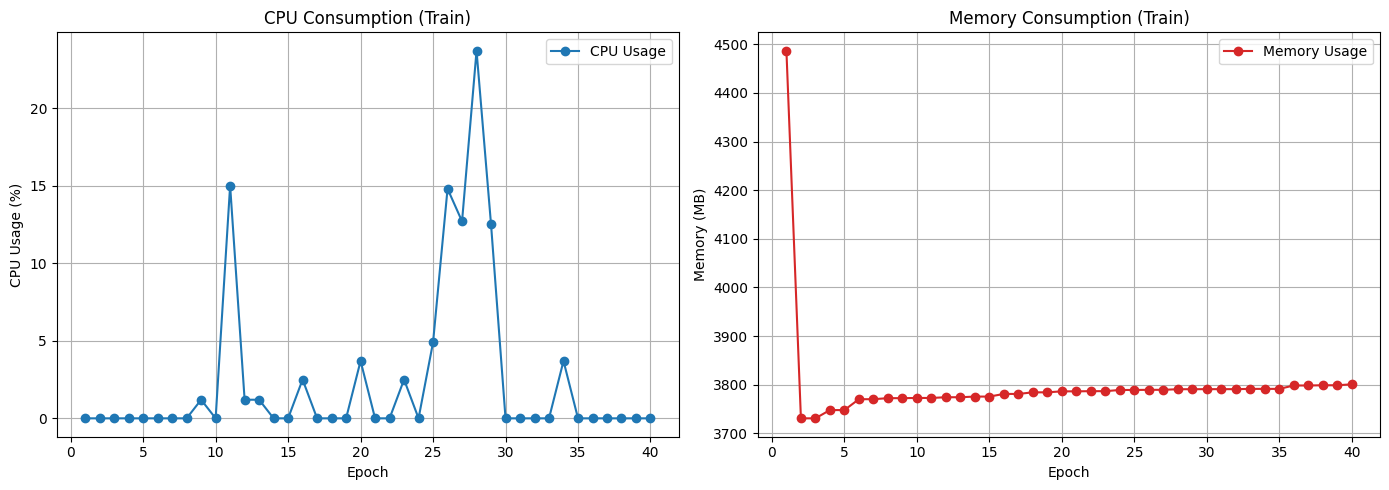

36866/36866 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.21 seconds
Average CPU usage (Test): 2.05%
Average memory usage (Test): 3970.57 MB
Estimated energy consumption: 904.68 Joules


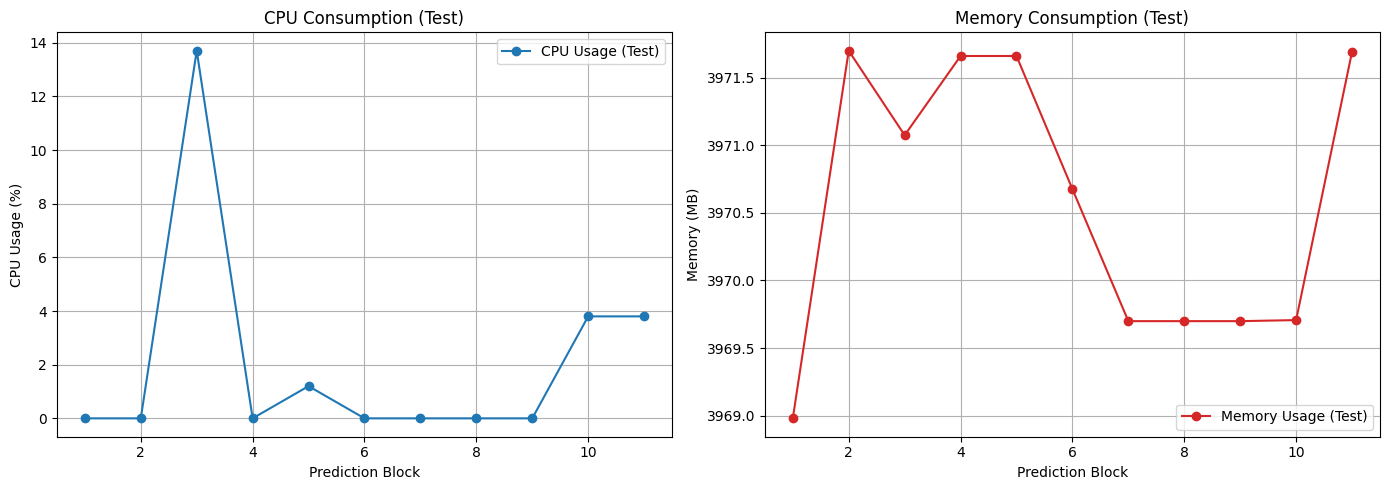

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.09 seconds
Average CPU usage (Test): 0.56%
Average memory usage (Test): 3362.80 MB
Estimated energy consumption: 2.99 Joules


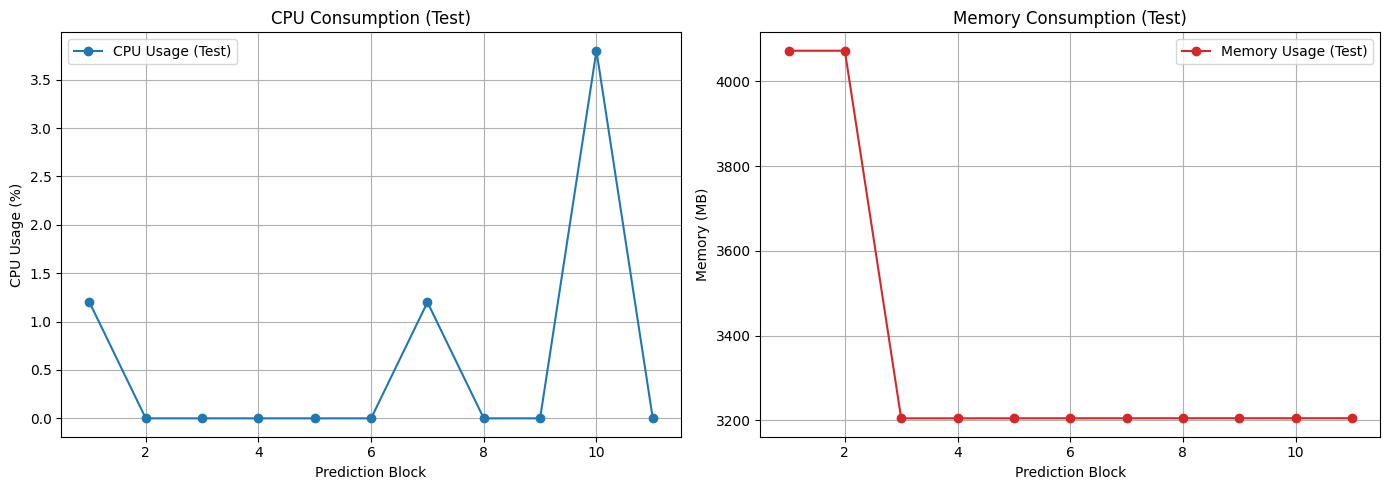

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 2.9471061140324633
ROC FULL=0.5035
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 2.9471061140324633
PR FULL=0.6033

====== Zero-Day: UDPFlood ======
Total UDPFlood in the original dataset: 457340
  Zero-days removed from training: 365919
  Zero-day in the original test: 91421
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 7.60%, Memory: 3864.28 MB
[Epoch 1 - End] CPU: 3.70%, Memory: 3162.03 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 3162.01 MB
[Epoch 2 - End] CPU: 16.20%, Memory: 3177.97 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 3177.95 MB
[Epoch 3 - End] CPU: 1.30%, Memory: 3188.75 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 3188.73 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3194.26 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 3194.23 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3194.39 MB

[Epoch 6 - Start] CPU: 15.00%, Memory: 3194.37 MB
[Epoch 6 

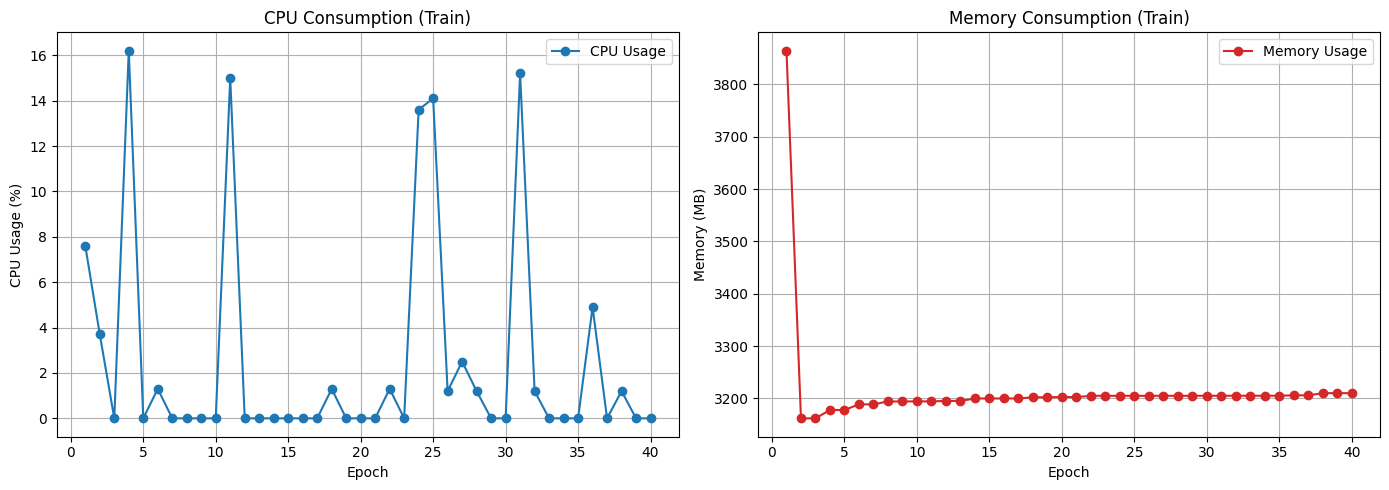

23872/23872 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.97 seconds
Average CPU usage (Test): 3.55%
Average memory usage (Test): 3492.96 MB
Estimated energy consumption: 5017.95 Joules


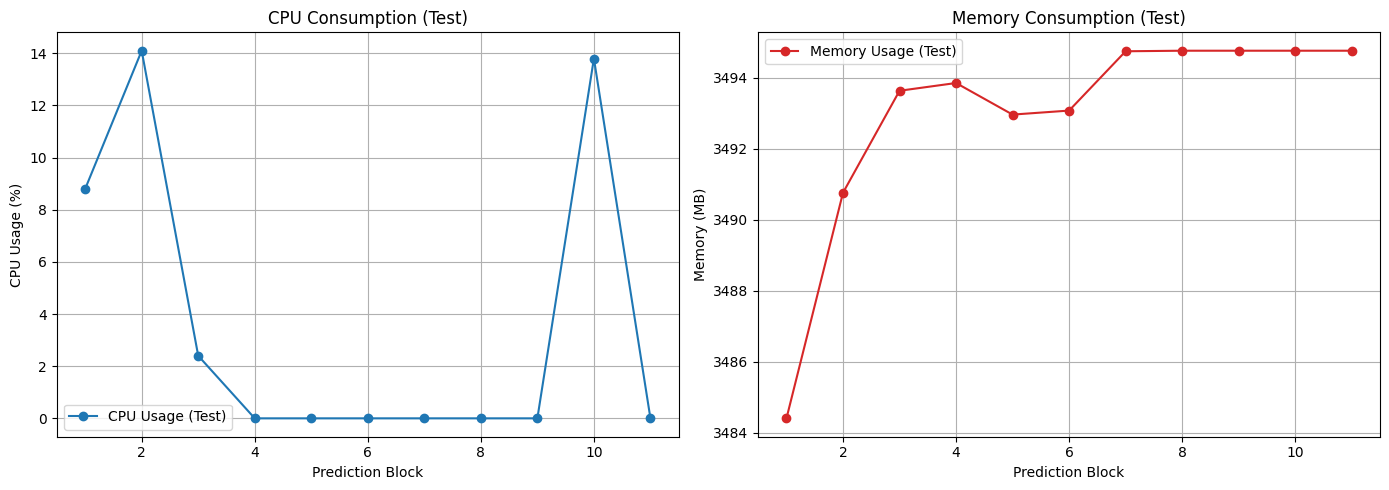

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 6.66 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 3118.24 MB
Estimated energy consumption: 5.00 Joules


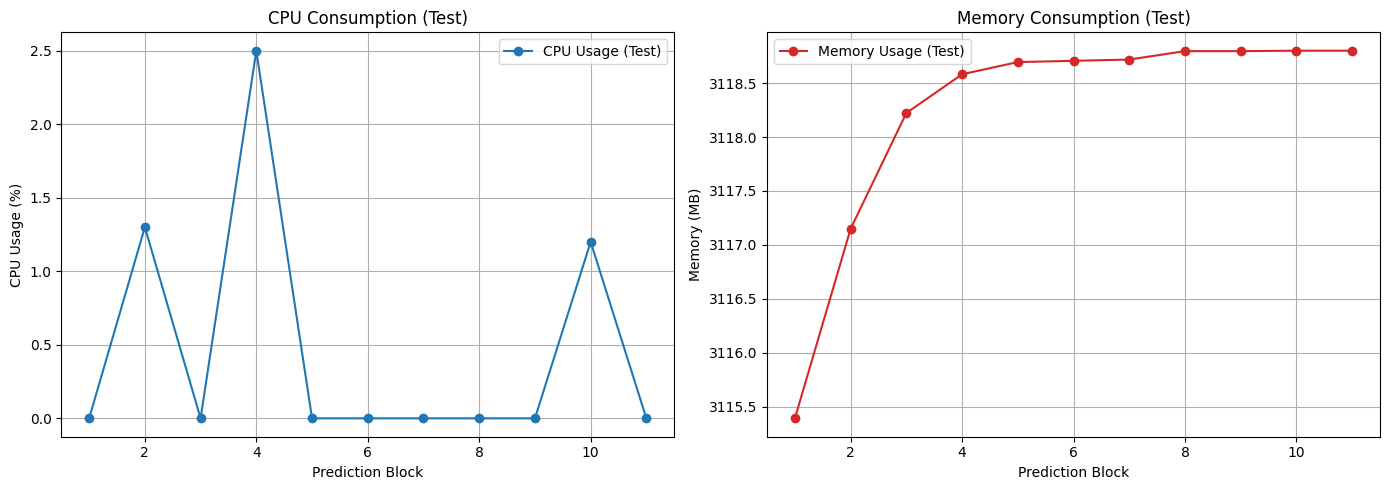

2857/2857 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
STD reconstruction error: 2.050662728818476
ROC FULL=0.3772
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD reconstruction error: 2.050662728818476
PR FULL=0.5105

====== Zero-Day: SYNFlood ======
Total SYNFlood in the original dataset: 9721
  Zero-days removed from training: 7802
  Zero-day in the original test: 1919
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 4212.45 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 3565.39 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 3565.39 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 3596.62 MB

[Epoch 3 - Start] CPU: 0.00%, Memory: 3596.59 MB
[Epoch 3 - End] CPU: 2.50%, Memory: 3606.13 MB

[Epoch 4 - Start] CPU: 0.00%, Memory: 3606.11 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3611.07 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 3611.05 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3611.19 MB

[End of Training]
Total time: 116.14 seconds
Average CPU usa

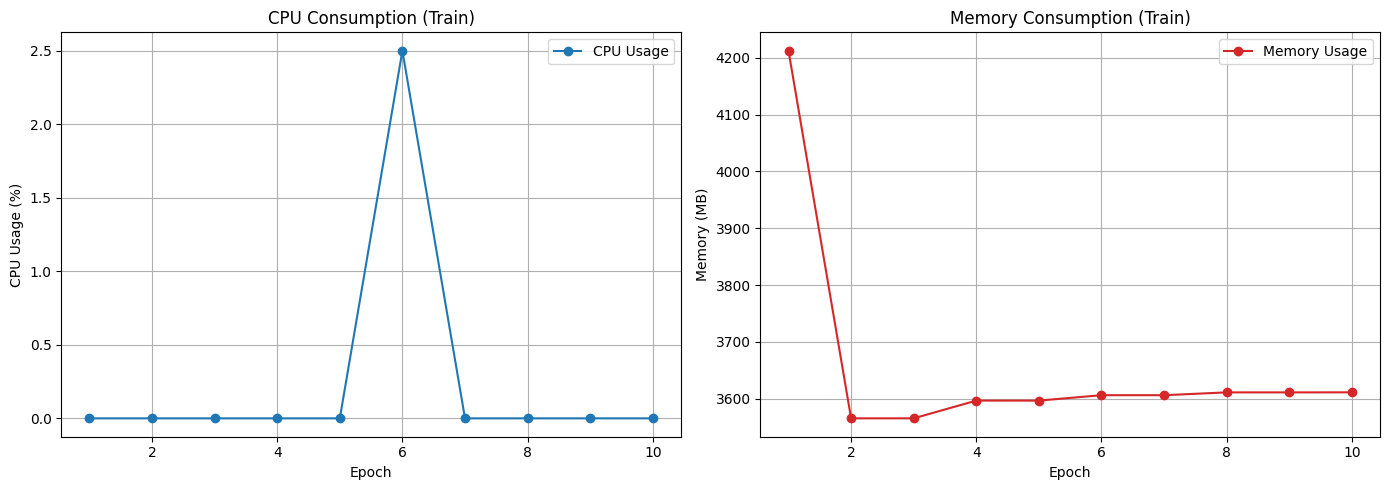

36436/36436 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 14.06 seconds
Average CPU usage (Test): 1.69%
Average memory usage (Test): 3756.00 MB
Estimated energy consumption: 543.89 Joules


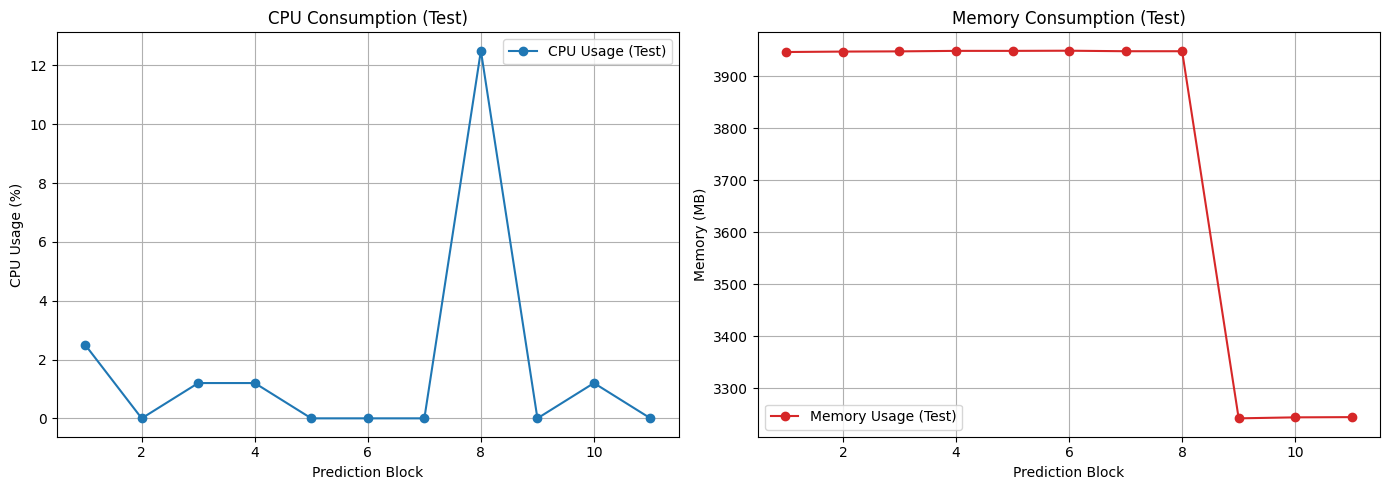

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.18 seconds
Average CPU usage (Test): 1.11%
Average memory usage (Test): 3469.79 MB
Estimated energy consumption: 23.74 Joules


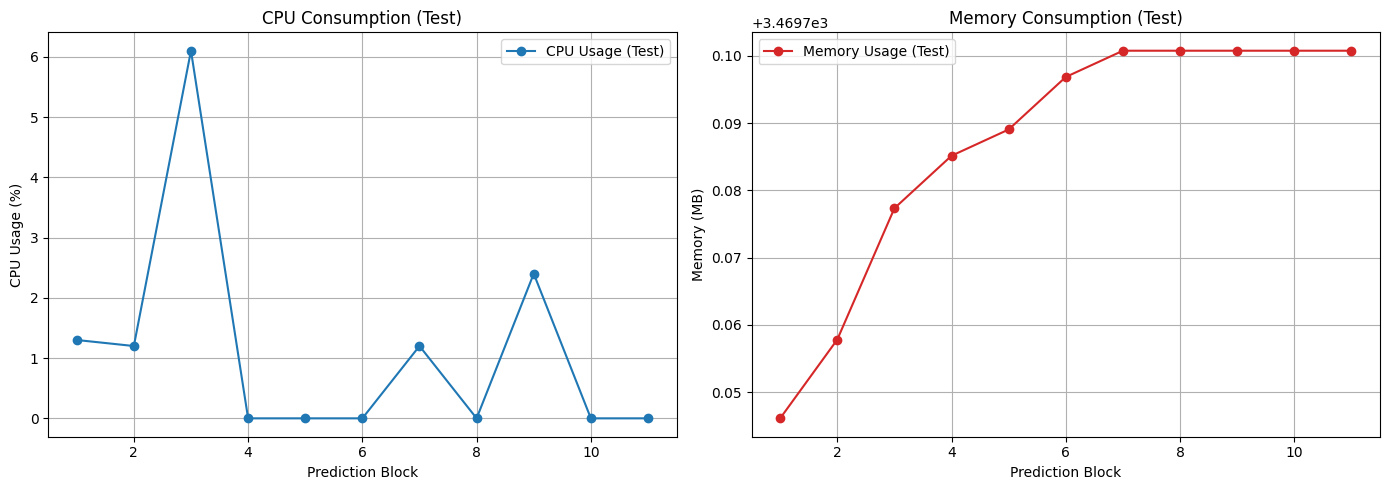

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
STD reconstruction error: 2.9138291810138575
ROC FULL=0.5048
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 2.9138291810138575
PR FULL=0.6045

====== Zero-Day: SYNScan ======
Total SYNScan in the original dataset: 20043
  Zero-days removed from training: 16149
  Zero-day in the original test: 3894
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 4196.90 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 3596.54 MB

[Epoch 2 - Start] CPU: 12.70%, Memory: 3596.52 MB
[Epoch 2 - End] CPU: 3.80%, Memory: 3626.39 MB

[Epoch 3 - Start] CPU: 1.20%, Memory: 3626.37 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 3636.69 MB

[Epoch 4 - Start] CPU: 1.20%, Memory: 3642.70 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3646.04 MB

[Epoch 5 - Start] CPU: 11.50%, Memory: 3646.02 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3646.18 MB

[End of Training]
Total time: 116.80 seconds
Average CPU usag

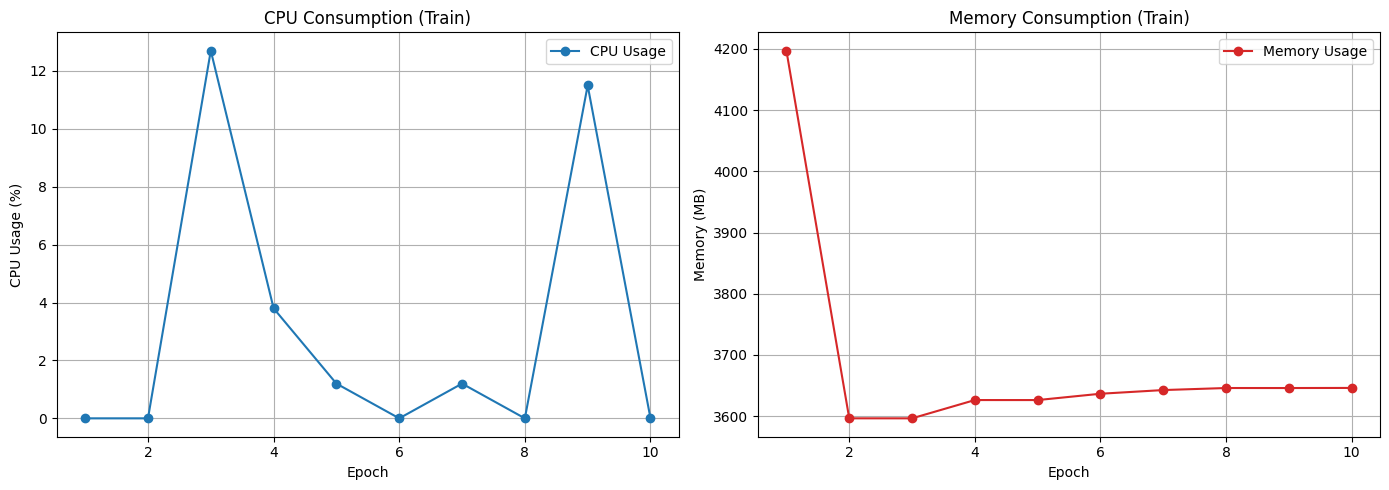

35914/35914 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.43 seconds
Average CPU usage (Test): 2.45%
Average memory usage (Test): 3630.56 MB
Estimated energy consumption: 1588.85 Joules


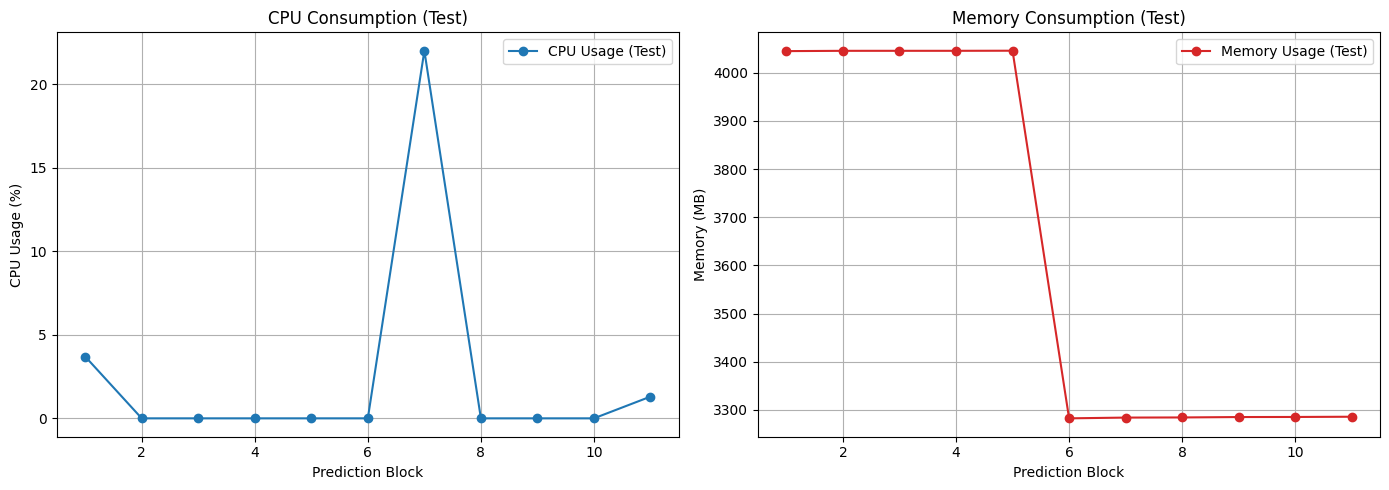

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.30 seconds
Average CPU usage (Test): 0.46%
Average memory usage (Test): 3486.45 MB
Estimated energy consumption: 1.84 Joules


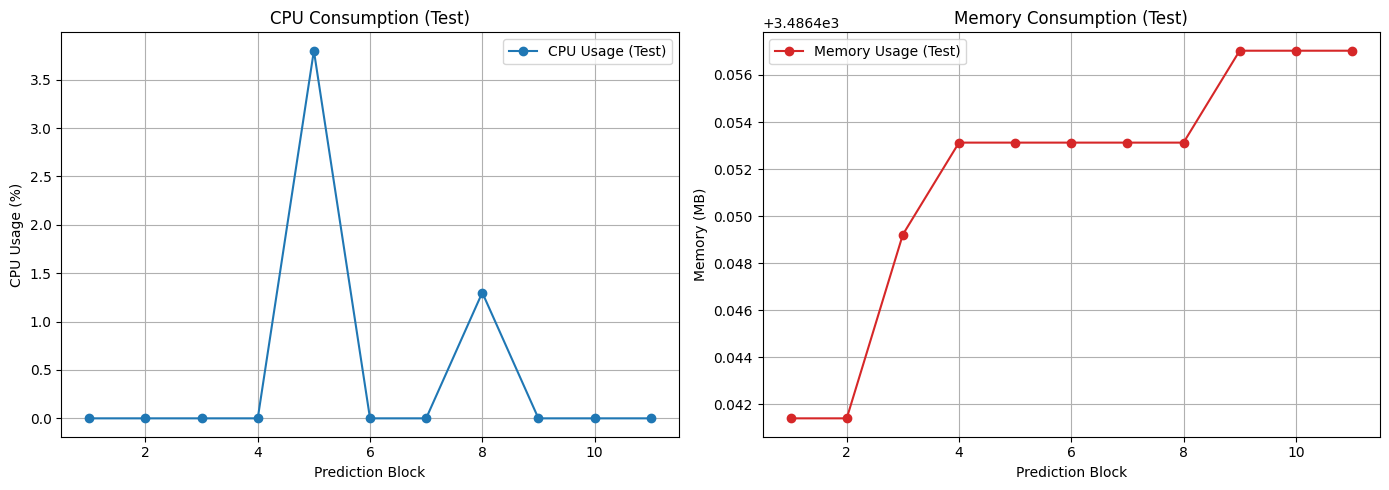

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 2.8750756850801245
ROC FULL=0.5059
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
STD reconstruction error: 2.8750756850801245
PR FULL=0.6060

====== Zero-Day: HTTPFlood ======
Total HTTPFlood in the original dataset: 140812
  Zero-days removed from training: 112649
  Zero-day in the original test: 28163
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 4295.73 MB
[Epoch 1 - End] CPU: 3.70%, Memory: 3446.06 MB

[Epoch 2 - Start] CPU: 0.00%, Memory: 3446.04 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 3472.25 MB

[Epoch 3 - Start] CPU: 3.80%, Memory: 3472.23 MB
[Epoch 3 - End] CPU: 16.50%, Memory: 3475.02 MB

[Epoch 4 - Start] CPU: 13.90%, Memory: 3474.99 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3479.03 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 3479.00 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3479.93 MB

[End of Training]
Total time: 98.99 seconds
Average 

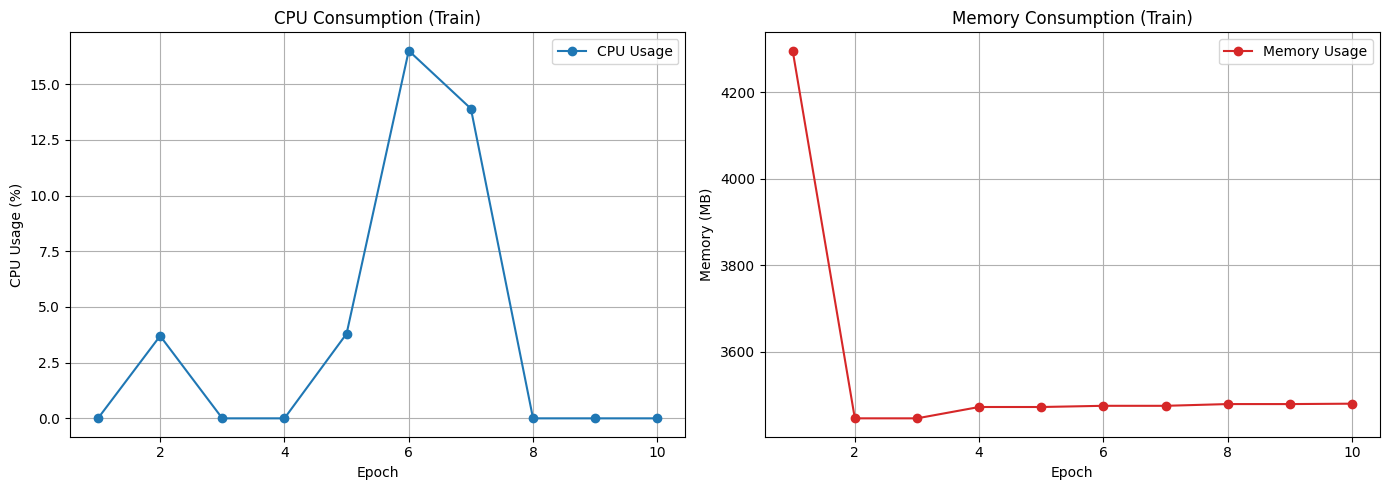

29883/29883 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.67 seconds
Average CPU usage (Test): 3.21%
Average memory usage (Test): 3305.19 MB
Estimated energy consumption: 3614.91 Joules


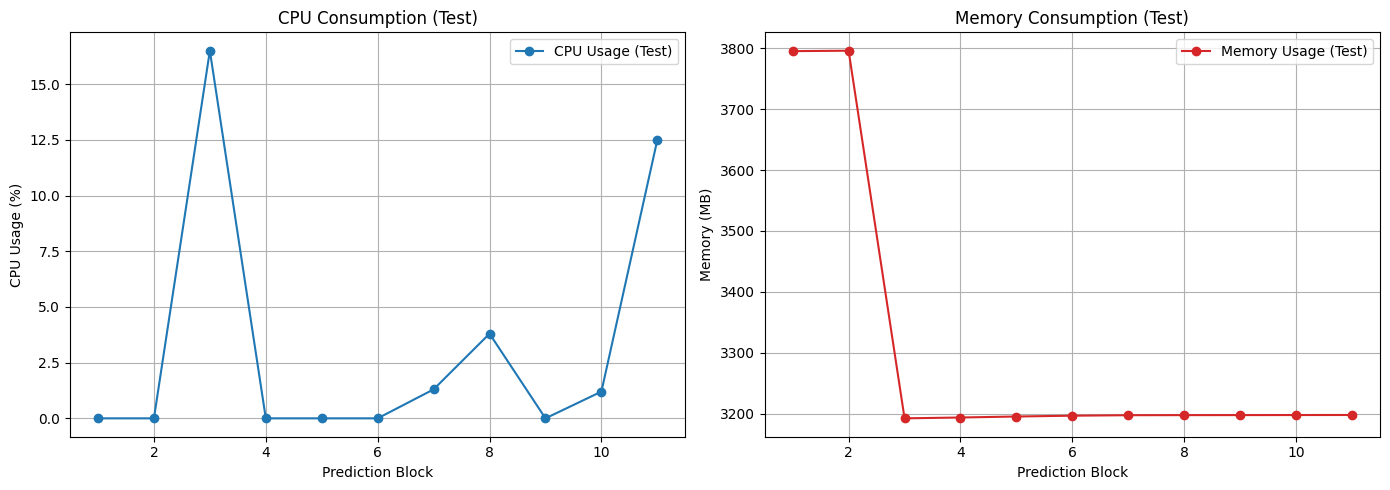

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 3.45 seconds
Average CPU usage (Test): 0.35%
Average memory usage (Test): 3394.91 MB
Estimated energy consumption: 1.14 Joules


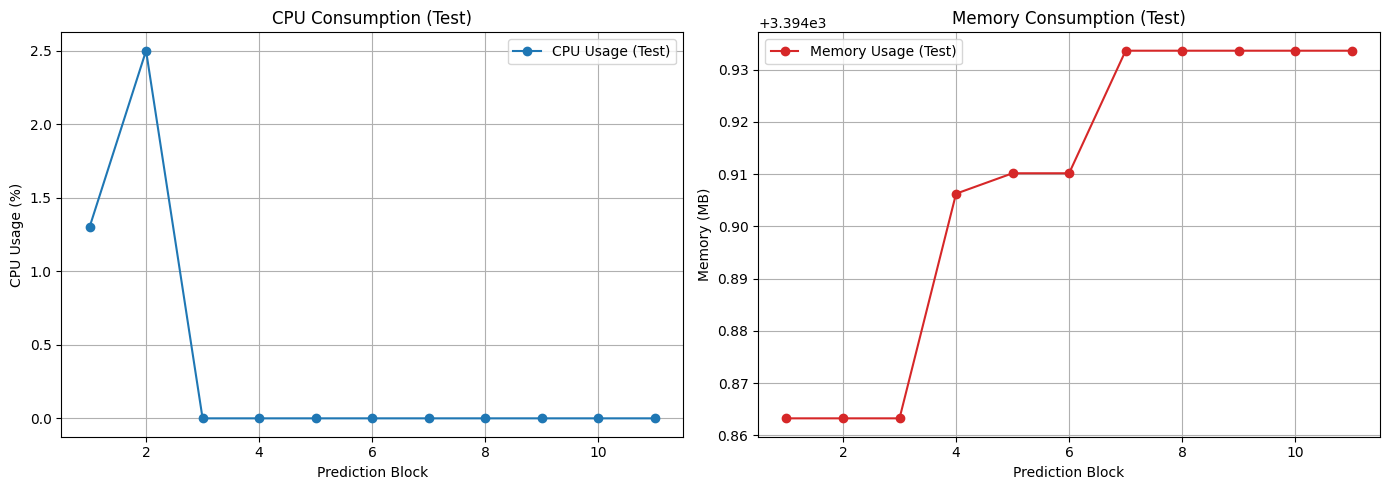

881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 4.293897232284074
ROC FULL=0.5303
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
STD reconstruction error: 4.293897232284074
PR FULL=0.6515

====== Zero-Day: UDPScan ======
Total UDPScan in the original dataset: 15906
  Zero-days removed from training: 12713
  Zero-day in the original test: 3193
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 0.00%, Memory: 4253.70 MB
[Epoch 1 - End] CPU: 1.20%, Memory: 3680.38 MB

[Epoch 2 - Start] CPU: 12.70%, Memory: 3680.35 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 3721.49 MB

[Epoch 3 - Start] CPU: 15.20%, Memory: 3721.47 MB
[Epoch 3 - End] CPU: 2.50%, Memory: 3722.64 MB

[Epoch 4 - Start] CPU: 17.50%, Memory: 3722.61 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3723.11 MB

[Epoch 5 - Start] CPU: 13.70%, Memory: 3723.09 MB
[Epoch 5 - End] CPU: 0.00%, Memory: 3727.67 MB

[End of Training]
Total time: 117.55 seconds
Average CPU usa

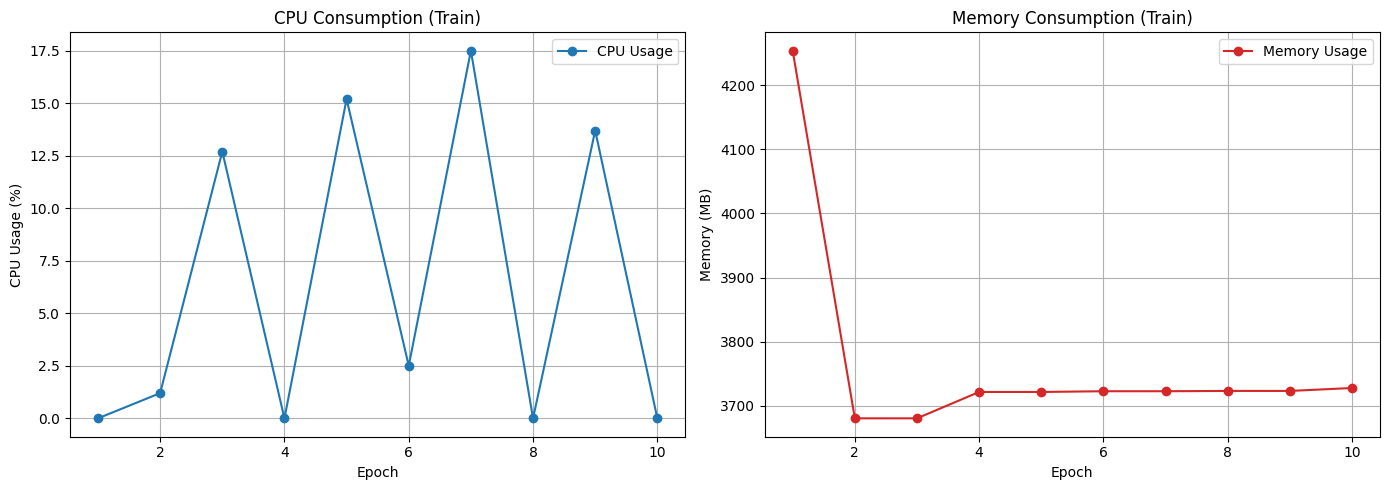

36129/36129 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.44 seconds
Average CPU usage (Test): 1.69%
Average memory usage (Test): 3454.49 MB
Estimated energy consumption: 519.85 Joules


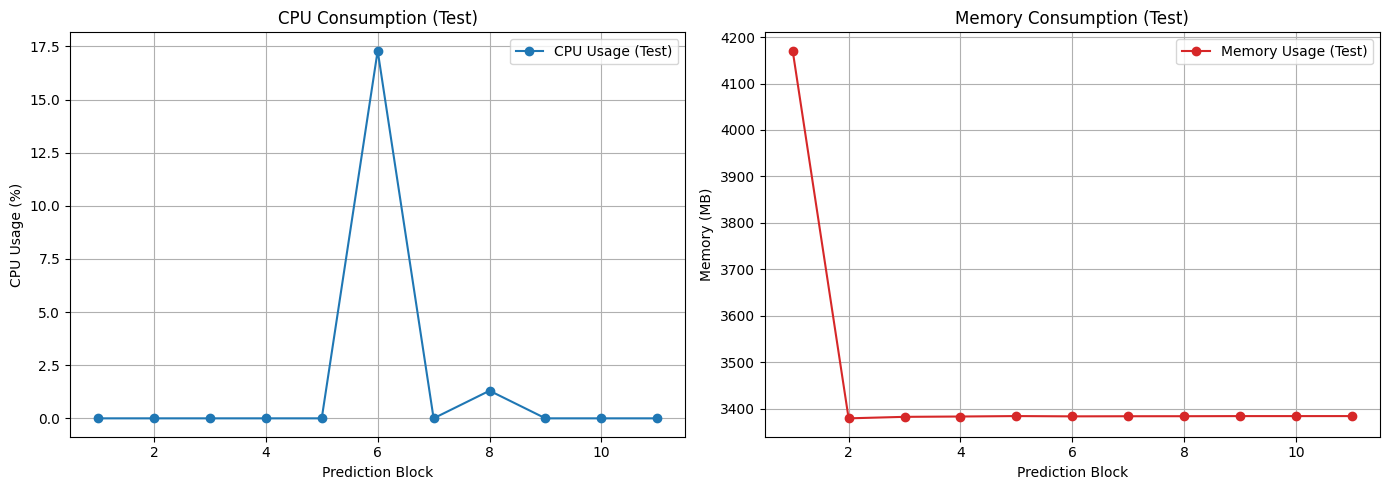

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.33 seconds
Average CPU usage (Test): 3.52%
Average memory usage (Test): 3576.67 MB
Estimated energy consumption: 810.91 Joules


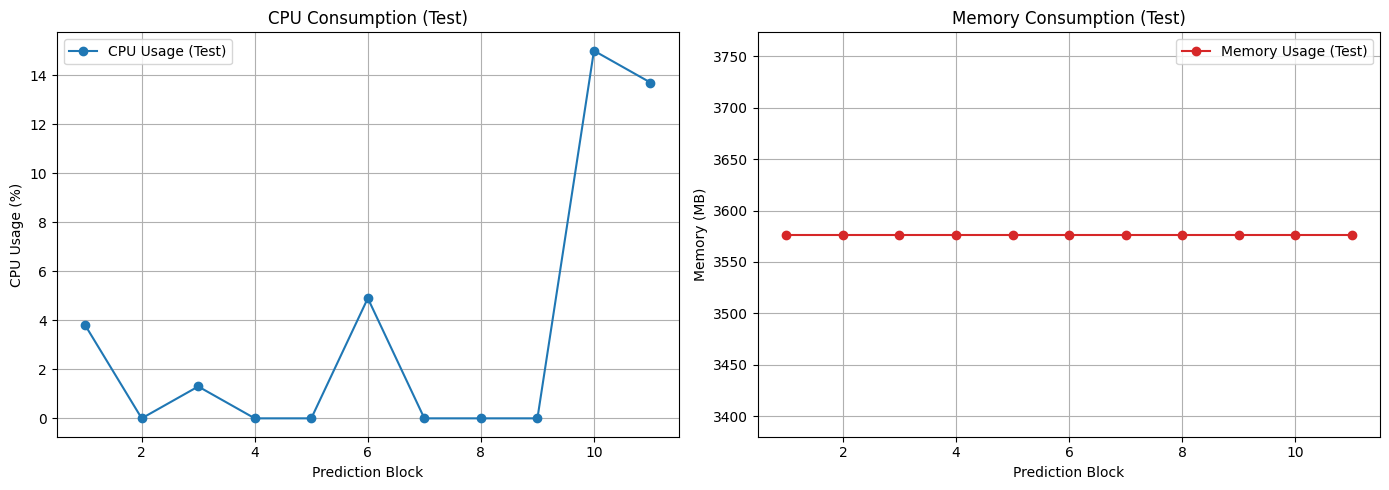

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD reconstruction error: 2.907706076055136
ROC FULL=0.4062
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
STD reconstruction error: 2.907706076055136
PR FULL=0.5696

====== Zero-Day: TCPConnectScan ======
Total TCPConnectScan in the original dataset: 20052
  Zero-days removed from training: 15999
  Zero-day in the original test: 4053
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 2.50%, Memory: 4331.30 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 3646.23 MB

[Epoch 2 - Start] CPU: 2.50%, Memory: 3646.21 MB
[Epoch 2 - End] CPU: 0.00%, Memory: 3702.70 MB

[Epoch 3 - Start] CPU: 1.30%, Memory: 3702.67 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 3704.18 MB

[Epoch 4 - Start] CPU: 6.20%, Memory: 3704.15 MB
[Epoch 4 - End] CPU: 2.50%, Memory: 3705.04 MB

[Epoch 5 - Start] CPU: 0.00%, Memory: 3705.02 MB
[Epoch 5 - End] CPU: 3.70%, Memory: 3713.50 MB

[End of Training]
Total time: 120.00 seconds
Ave

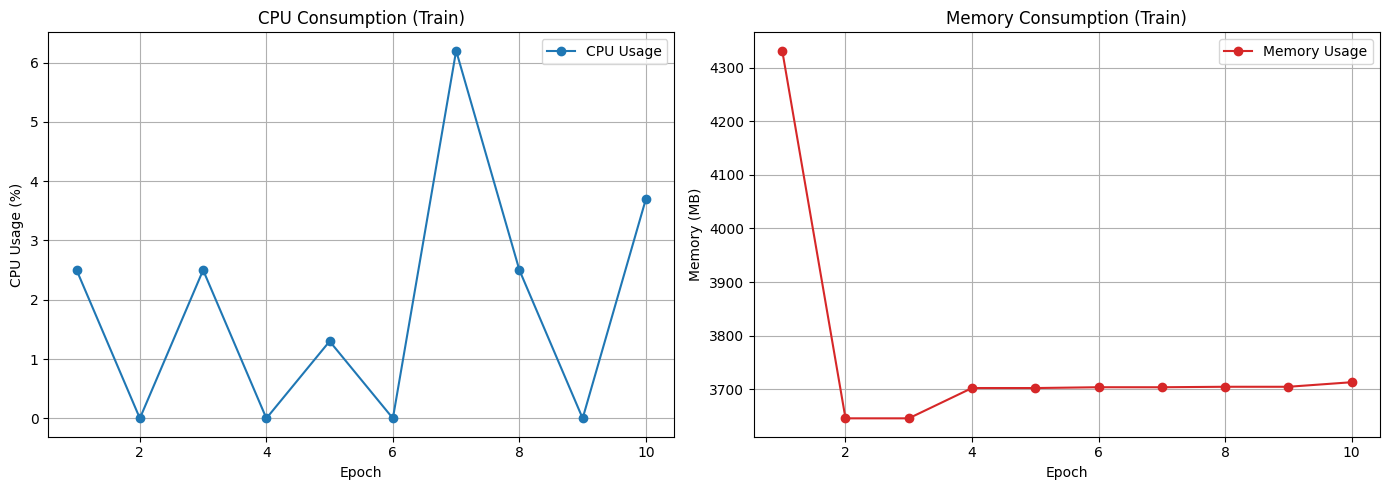

35924/35924 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 14.48 seconds
Average CPU usage (Test): 1.90%
Average memory usage (Test): 4176.18 MB
Estimated energy consumption: 794.73 Joules


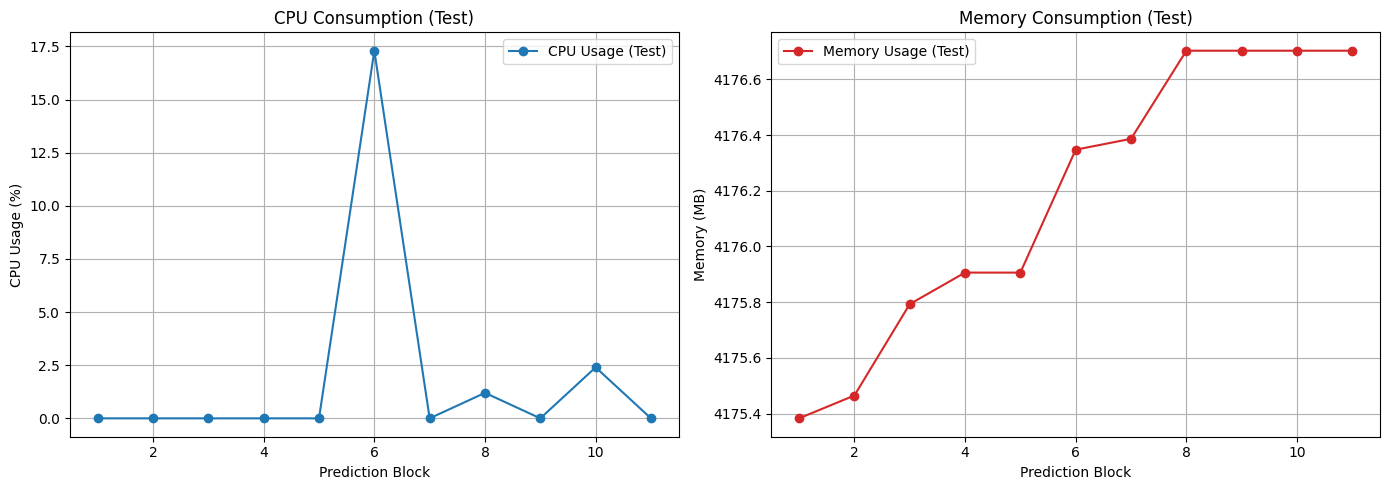

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.54 seconds
Average CPU usage (Test): 6.61%
Average memory usage (Test): 4317.41 MB
Estimated energy consumption: 5858.10 Joules


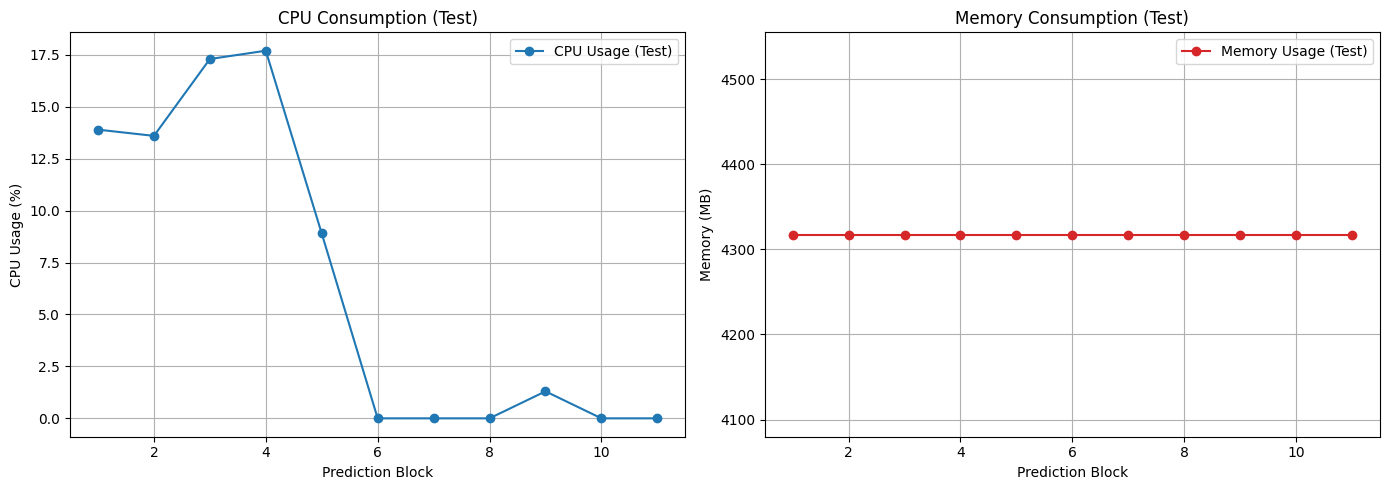

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD reconstruction error: 2.8766906544438657
ROC FULL=0.5049
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD reconstruction error: 2.8766906544438657
PR FULL=0.6036

====== Zero-Day: SlowrateDoS ======
Total SlowrateDoS in the original dataset: 73124
  Zero-days removed from training: 58621
  Zero-day in the original test: 14503
  Test full total: 243178

[Start of Training]

[Epoch 1 - Start] CPU: 1.20%, Memory: 3545.65 MB
[Epoch 1 - End] CPU: 0.00%, Memory: 3669.50 MB

[Epoch 2 - Start] CPU: 3.80%, Memory: 3669.47 MB
[Epoch 2 - End] CPU: 4.90%, Memory: 3687.14 MB

[Epoch 3 - Start] CPU: 1.30%, Memory: 3687.12 MB
[Epoch 3 - End] CPU: 0.00%, Memory: 3694.09 MB

[Epoch 4 - Start] CPU: 1.30%, Memory: 3694.07 MB
[Epoch 4 - End] CPU: 0.00%, Memory: 3700.59 MB

[Epoch 5 - Start] CPU: 1.30%, Memory: 3700.57 MB
[Epoch 5 - End] CPU: 13.60%, Memory: 3707.03 MB

[End of Training]
Total time: 109.23 seconds
Avera

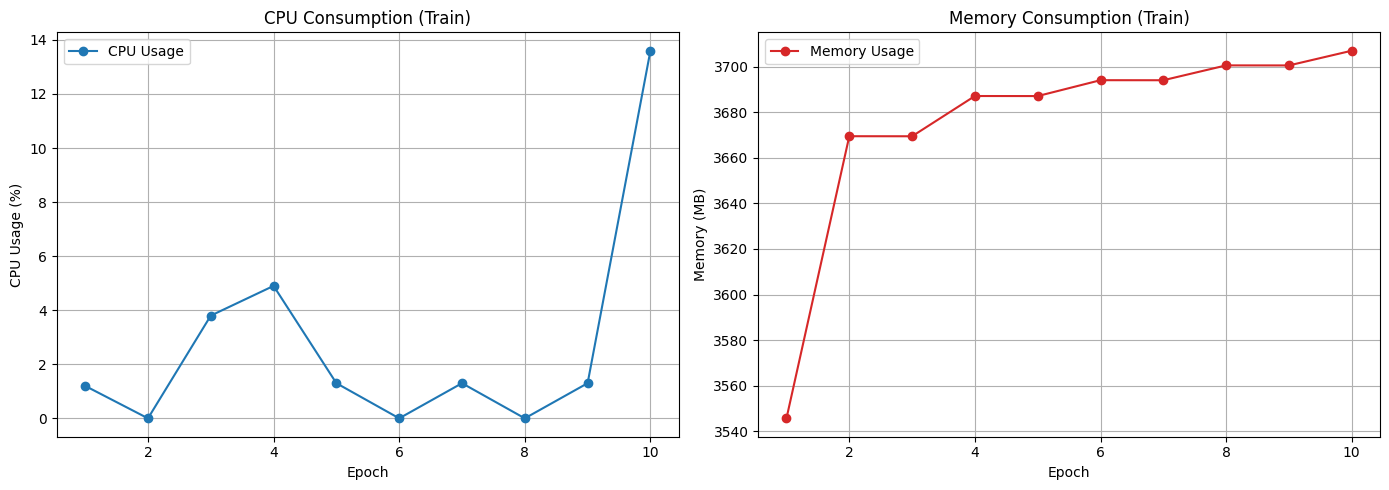

33260/33260 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 13.54 seconds
Average CPU usage (Test): 1.92%
Average memory usage (Test): 4145.54 MB
Estimated energy consumption: 764.40 Joules


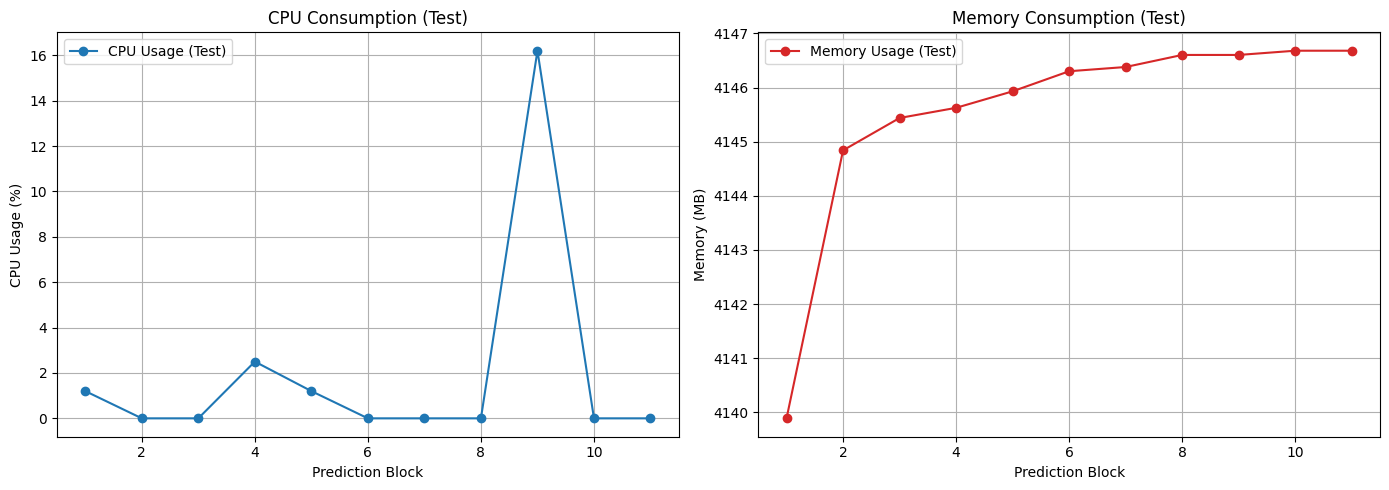

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.98 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 4265.71 MB
Estimated energy consumption: 7.55 Joules


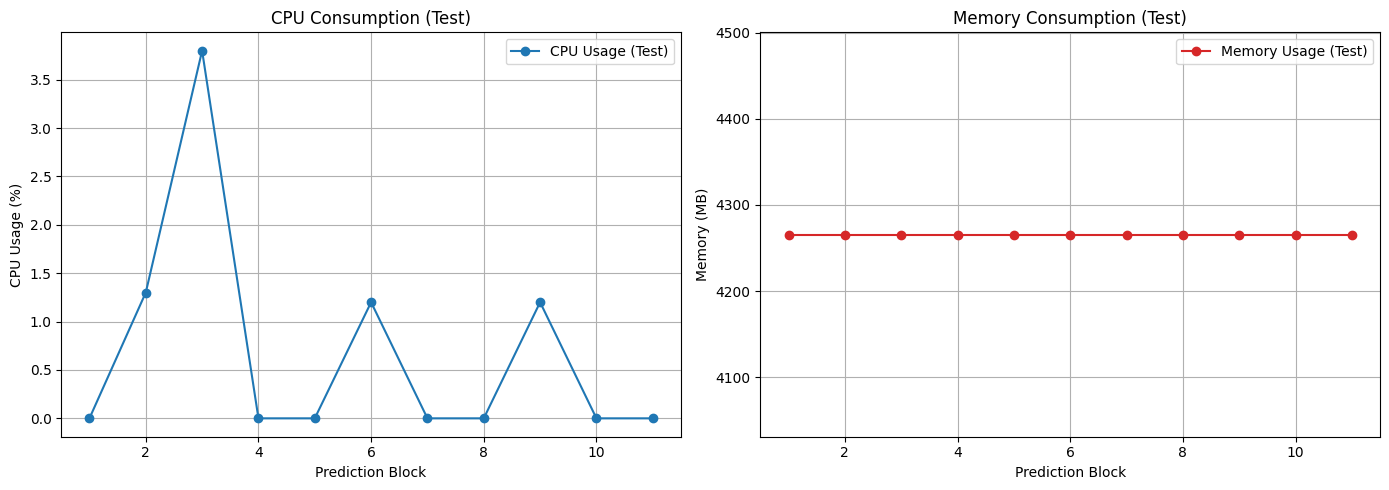

454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
STD reconstruction error: 4.690301480834916
ROC FULL=0.5150
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
STD reconstruction error: 4.690301480834916
PR FULL=0.6133


In [56]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os


# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood', 'SYNScan', 'HTTPFlood', 'UDPScan', 'TCPConnectScan', 'SlowrateDoS']
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "Autoencoder"
roc_full_curves = []
pr_full_curves = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Contagem no dataset original ---
    total_in_original = (X['Attack Type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} in the original dataset: {total_in_original}")
    mask_train = X_train['Attack Type'] != ataque_zero_day
    train_removed = (~mask_train).sum()

    X_train_clean = X_train.loc[mask_train].drop(columns=['Attack Type']).copy()
    y_train_clean = y_train.loc[mask_train].copy()
    print(f"  Zero-days removed from training: {train_removed}")

    mask_test_zero = X_test['Attack Type'] == ataque_zero_day
    X_test_zero_day = X_test.loc[mask_test_zero].drop(columns=['Attack Type']).copy()
    y_test_zero_day = y_test.loc[mask_test_zero].copy()
    print(f"  Zero-day in the original test: {mask_test_zero.sum()}")

    X_test_full = X_test.drop(columns=['Attack Type']).copy()
    y_test_full = y_test.copy()
    print(f"  Test full total: {len(X_test_full)}")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # --- Construção do Autoencoder ---
    input_dim = X_train_scaled.shape[1]
    encoding_dim = 32  # latente

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation="relu")(input_layer)
    encoded = Dense(encoding_dim, activation="relu")(encoded)
    decoded = Dense(64, activation="relu")(encoded)
    output_layer = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")

    # --- Treinamento com monitoramento ---
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # =============================
    # Definir threshold (a partir do treino benigno)
    # =============================
    recon_train = autoencoder.predict(X_train_scaled)
    train_errors = np.mean(np.power(X_train_scaled - recon_train, 2), axis=1)
    threshold = np.percentile(train_errors, 70)

    # =============================
    # Função para calcular métricas
    # =============================
    def avaliar(autoencoder, X, y_true, threshold):
        recon = autoencoder.predict(X)
        errors = np.mean(np.power(X - recon, 2), axis=1)
        y_pred = (errors > threshold).astype(int)
        return {
            "F1": f1_score(y_true, y_pred, zero_division=1),
            "Precision": precision_score(y_true, y_pred, zero_division=1),
            "Recall": recall_score(y_true, y_pred, zero_division=1),
            "Accuracy": accuracy_score(y_true, y_pred)
        }

    # =============================
    # Codificação dos rótulos
    # =============================
    y_test_full_encoded = (y_test_full != "Benign").astype(int)
    y_test_zero_day_encoded = (y_test_zero_day != "Benign").astype(int)

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    print('\n====== General Resource Allocation ======')
    metrics_test_full = monitor_test_prediction(autoencoder, X_test_full_scaled)
    result_full = avaliar(autoencoder, X_test_full_scaled, y_test_full_encoded, threshold)

    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    print('\n====== Zero-Day Resource Allocation ======')
    metrics_zero_day = monitor_test_prediction(autoencoder, X_test_zero_day_scaled)
    result_zero = avaliar(autoencoder, X_test_zero_day_scaled, y_test_zero_day_encoded, threshold)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Attack Zero-Day': ataque_zero_day,

    'Accuracy': result_full['Accuracy'],
    'F1': result_full['F1'],
    'Precision': result_full['Precision'],
    'Recall': result_full['Recall'],
    'Time': metrics_test_full['total_time'],
    'CPU': metrics_test_full['avg_cpu'],
    'Memory': metrics_test_full['avg_mem'],
    'Energy': metrics_test_full['energia'],

    'ZD - Accuracy': result_zero['Accuracy'],
    'ZD - F1': result_zero['F1'],
    'ZD - Precision': result_zero['Precision'],
    'ZD - Recall': result_zero['Recall'],
    'ZD - Time': metrics_zero_day['total_time'],
    'ZD - CPU': metrics_zero_day['avg_cpu'],
    'ZD - Memory': metrics_zero_day['avg_mem'],
    'ZD - Energy': metrics_zero_day['energia'],
  })
    # =============================
    # CURVA ROC (AUTOENCODER) - TESTE FULL
    # =============================

    # Predição
    X_pred = autoencoder.predict(X_test_full_scaled)

    # Erro por amostra
    reconstruction_error = np.mean(np.square(X_test_full_scaled - X_pred), axis=1)

    # Verificação de valores constantes (debug)
    print("STD reconstruction error:", np.std(reconstruction_error))

    # Score contínuo
    probs_full = reconstruction_error

    # Garante que os rótulos são 0 (benign) e 1 (attack)
    y_test_full_bin = (y_test_full != 'Benign').astype(int)

    # Geração da ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_full_bin, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, ataque_zero_day))

    print(f"ROC FULL={roc_auc_full:.4f}")

    # =============================
    # PR CURVE (AUTOENCODER) - TESTE FULL
    # =============================

    # Predição
    X_pred = autoencoder.predict(X_test_full_scaled)

    # Erro por amostra
    reconstruction_error = np.mean(np.square(X_test_full_scaled - X_pred), axis=1)

    # Verificação de valores constantes (debug)
    print("STD reconstruction error:", np.std(reconstruction_error))

    # Score contínuo (maior erro = maior chance de ataque)
    probs_full = reconstruction_error

    # Geração da PR-Curve
    precision_full, recall_full, _ = precision_recall_curve(y_test_full_encoded, probs_full)
    ap_full = average_precision_score(y_test_full_encoded, probs_full)

    # Armazena no array geral igual à ROC
    pr_full_curves.append((precision_full, recall_full, ap_full, ataque_zero_day))

    print(f"PR FULL={ap_full:.4f}")

    del autoencoder
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


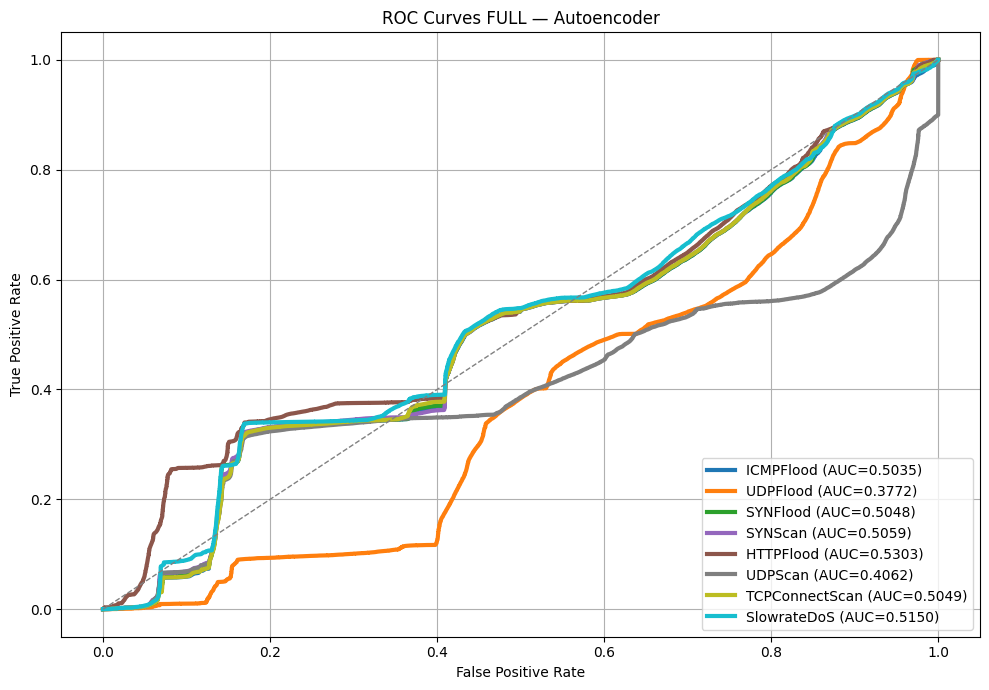

In [57]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

/tmp/ipython-input-3942214508.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pr_full_curves))


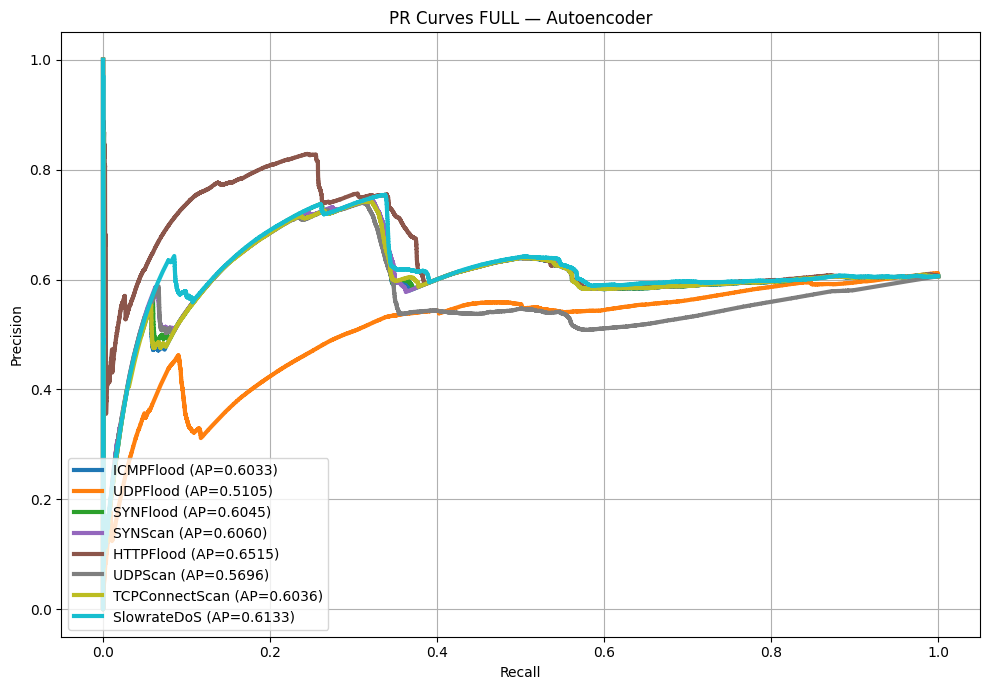

In [58]:
# =========================================
# Após o loop, gera um gráfico com todas as PR CURVES (FULL)
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(pr_full_curves))

for i, (precision, recall, ap_val, label) in enumerate(pr_full_curves):
    plt.plot(recall, precision, lw=3, color=colors(i),
             label=f"{label} (AP={ap_val:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curves FULL — {model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()

os.makedirs("pr_curves", exist_ok=True)
plt.savefig(f"pr_curves/{model_name}_ALL_FULL_PR.png", dpi=400)
plt.show()

In [59]:
!pip install tabulate

In [60]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤═════════╤═════════╤══════════╤══════════╤═════════════════╤═══════════╤══════════════════╤═══════════════╤═════════════╤════════════╤═══════════════╤═══════════════╕
│ Attack Zero-Day   │   Accuracy │       F1 │   Precision │   Recall │    Time │     CPU │   Memory │   Energy │   ZD - Accuracy │   ZD - F1 │   ZD - Precision │   ZD - Recall │   ZD - Time │   ZD - CPU │   ZD - Memory │   ZD - Energy │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪═════════╪═════════╪══════════╪══════════╪═════════════════╪═══════════╪══════════════════╪═══════════════╪═════════════╪════════════╪═══════════════╪═══════════════╡
│ ICMPFlood         │   0.494305 │ 0.447149 │    0.662621 │ 0.337425 │ 13.2141 │ 2.04545 │  3970.57 │  904.684 │     1           │ 1         │                1 │   1           │     2.08599 │   0.563636 │       3362.8  │       2.98813 │
├───────────────────┼────────────┼──────────┼───────

In [61]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')